In [1]:
#!pip install --quiet --upgrade fastmcp langchain-mcp-adapters langgraph langchain-openai

In [2]:
from typing import TypedDict, List, Dict
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI, AzureChatOpenAI
from langchain_neo4j import Neo4jGraph
from langchain.prompts import ChatPromptTemplate
import os

In [3]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key")

Enter your OpenAI API key ········


In [5]:
llm = ChatOpenAI(model="gpt-5-mini")

graph = Neo4jGraph(
    url=os.getenv("NEO4J_URI", "neo4j+s://demo.neo4jlabs.com"),
    username=os.getenv("NEO4J_USERNAME", "recommendations"),
    password=os.getenv("NEO4J_PASSWORD", "recommendations"),
    database=os.getenv("NEO4J_DATABASE", "recommendations"),
    refresh_schema=False
)

In [6]:
# State definition
class MovieAnalysisState(TypedDict):
    analysis_focus: str  # genres, actors, themes, etc.
    top_genres: List[Dict]
    successful_actors: List[Dict]
    profitable_patterns: Dict
    director_insights: List[Dict]
    genre_combinations: List[Dict]
    market_trends: str
    strategic_reasoning: str  # LLM reasoning before generating concepts
    concept_ideas: List[Dict]
    final_report: str

# Node 1: Analyze top-performing genres by IMDB rating
def analyze_top_genres(state: MovieAnalysisState) -> MovieAnalysisState:
    """Find genres with highest average IMDB ratings"""
    query = """
    MATCH (m:Movie)-[:IN_GENRE]->(g:Genre)
    WHERE m.imdbRating IS NOT NULL
    WITH g.name as genre, 
         avg(m.imdbRating) as avg_rating,
         count(m) as movie_count,
         collect(m.title)[..3] as sample_movies
    WHERE movie_count >= 5
    RETURN genre, 
           round(avg_rating * 100) / 100 as avg_rating,
           movie_count,
           sample_movies
    ORDER BY avg_rating DESC
    LIMIT 10
    """
    
    result = graph.query(query)
    return {**state, "top_genres": result}

# Node 2: Identify bankable actors
def identify_successful_actors(state: MovieAnalysisState) -> MovieAnalysisState:
    """Find actors with consistently high-rated movies"""
    query = """
    MATCH (a:Person)-[:ACTED_IN]->(m:Movie)
    WHERE m.imdbRating IS NOT NULL
    WITH a.name as actor,
         avg(m.imdbRating) as avg_rating,
         count(m) as movie_count,
         collect(m.title)[..3] as top_movies
    WHERE movie_count >= 3
    RETURN actor,
           round(avg_rating * 100) / 100 as avg_rating,
           movie_count,
           top_movies
    ORDER BY avg_rating DESC, movie_count DESC
    LIMIT 15
    """
    
    result = graph.query(query)
    return {**state, "successful_actors": result}

# Node 3: Analyze profitability patterns
def analyze_profitability(state: MovieAnalysisState) -> MovieAnalysisState:
    """Calculate ROI and profitability metrics"""
    query = """
    MATCH (m:Movie)
    WHERE m.revenue IS NOT NULL AND m.budget IS NOT NULL 
          AND m.budget > 0
    WITH m,
         toFloat(m.revenue) / toFloat(m.budget) as roi,
         toFloat(m.revenue) - toFloat(m.budget) as profit
    WHERE roi > 0
    WITH m, roi, profit
    ORDER BY roi DESC
    LIMIT 20
    WITH collect({
        title: m.title,
        roi: round(roi * 100) / 100,
        profit: profit,
        budget: m.budget,
        revenue: m.revenue,
        rating: m.imdbRating
    }) as top_roi_movies
    
    MATCH (m:Movie)
    WHERE m.revenue IS NOT NULL AND m.budget IS NOT NULL 
          AND m.budget > 0
    WITH top_roi_movies,
         avg(toFloat(m.revenue) / toFloat(m.budget)) as avg_roi,
         avg(toFloat(m.budget)) as avg_budget,
         avg(toFloat(m.revenue)) as avg_revenue
    
    RETURN top_roi_movies,
           round(avg_roi * 100) / 100 as avg_roi,
           round(avg_budget) as avg_budget,
           round(avg_revenue) as avg_revenue
    """
    
    result = graph.query(query)
    if result:
        return {**state, "profitable_patterns": result[0]}
    return {**state, "profitable_patterns": {}}

# Node 4: Analyze director track records
def analyze_directors(state: MovieAnalysisState) -> MovieAnalysisState:
    """Find directors with best track records"""
    query = """
    MATCH (d:Person)-[:DIRECTED]->(m:Movie)
    WHERE m.imdbRating IS NOT NULL
    WITH d.name as director,
         avg(m.imdbRating) as avg_rating,
         count(m) as movie_count,
         max(m.imdbRating) as best_rating,
         collect(m.title)[..3] as notable_works
    WHERE movie_count >= 2
    RETURN director,
           round(avg_rating * 100) / 100 as avg_rating,
           round(best_rating * 100) / 100 as best_rating,
           movie_count,
           notable_works
    ORDER BY avg_rating DESC, movie_count DESC
    LIMIT 10
    """
    
    result = graph.query(query)
    return {**state, "director_insights": result}

# Node 5: Analyze successful genre combinations
def analyze_genre_combinations(state: MovieAnalysisState) -> MovieAnalysisState:
    """Find genre combinations that work well together"""
    query = """
    MATCH (m:Movie)-[:IN_GENRE]->(g:Genre)
    WHERE m.imdbRating IS NOT NULL
    WITH m, collect(g.name) as genres
    WHERE size(genres) >= 2
    WITH genres, 
         avg(m.imdbRating) as avg_rating,
         count(m) as count
    WHERE count >= 3
    RETURN genres,
           round(avg_rating * 100) / 100 as avg_rating,
           count
    ORDER BY avg_rating DESC, count DESC
    LIMIT 10
    """
    
    result = graph.query(query)
    return {**state, "genre_combinations": result}

# Node 6: Synthesize market trends
def synthesize_trends(state: MovieAnalysisState) -> MovieAnalysisState:
    """Use LLM to identify trends from data"""
    top_genres = state.get("top_genres", [])
    actors = state.get("successful_actors", [])
    combos = state.get("genre_combinations", [])
    
    genres_text = "\n".join([
        f"- {g['genre']}: {g['avg_rating']} rating ({g['movie_count']} movies)"
        for g in top_genres[:5]
    ])
    
    actors_text = "\n".join([
        f"- {a['actor']}: {a['avg_rating']} avg rating ({a['movie_count']} films)"
        for a in actors[:5]
    ])
    
    combos_text = "\n".join([
        f"- {' + '.join(c['genres'])}: {c['avg_rating']} rating"
        for c in combos[:5]
    ])
    
    prompt = ChatPromptTemplate.from_template(
        """Analyze these movie industry patterns and identify 3-5 key market trends:
        
        TOP GENRES:
        {genres}
        
        SUCCESSFUL ACTORS:
        {actors}
        
        WINNING GENRE COMBINATIONS:
        {combos}
        
        Write a brief analysis of current market trends (3-4 paragraphs).
        """
    )
    
    result = llm.invoke(prompt.format_messages(
        genres=genres_text,
        actors=actors_text,
        combos=combos_text
    ))
    
    return {**state, "market_trends": result.content}

# Node 7: Strategic reasoning for concepts
def strategic_reasoning(state: MovieAnalysisState) -> MovieAnalysisState:
    """Have LLM reason through strategy before generating specific concepts"""
    top_genres = state.get("top_genres", [])
    actors = state.get("successful_actors", [])
    directors = state.get("director_insights", [])
    profitable = state.get("profitable_patterns", {})
    combos = state.get("genre_combinations", [])
    trends = state.get("market_trends", "")
    
    # Build context
    top_genre_list = [f"{g['genre']} ({g['avg_rating']}/10)" for g in top_genres[:5]]
    genre_combos_list = [f"{' + '.join(c['genres'])} ({c['avg_rating']}/10)" for c in combos[:5]]
    top_actors_summary = [f"{a['actor']} ({a['avg_rating']}/10)" for a in actors[:10]]
    top_directors_summary = [f"{d['director']} ({d['avg_rating']}/10)" for d in directors[:5]]
    
    avg_budget = profitable.get("avg_budget", 50000000)
    avg_roi = profitable.get("avg_roi", 2.0)
    top_roi_movies = profitable.get("top_roi_movies", [])[:5]
    
    roi_examples = "\n".join([
        f"- {m['title']}: {m['roi']}x ROI (${m['budget']:,.0f} → ${m['revenue']:,.0f})"
        for m in top_roi_movies
    ])
    
    prompt = ChatPromptTemplate.from_template(
        """You are a seasoned Hollywood producer reviewing market data to develop a slate strategy.

COMPLETE MARKET DATA:

Top Performing Genres:
{genres}

Successful Genre Combinations:
{combos}

Bankable Actors (with avg ratings):
{actors}

Proven Directors:
{directors}

Profitability Metrics:
- Average ROI: {roi}x
- Average Budget: ${budget:,.0f}

Top ROI Examples:
{roi_examples}

Market Trends Analysis:
{trends}

YOUR TASK:
Think step-by-step about what types of movies we should greenlight. Consider:

1. **Genre Strategy**: Which genres and combinations offer the best risk/reward?
2. **Talent Assembly**: How should we match actors and directors to maximize both quality and appeal?
3. **Budget Philosophy**: What budget ranges historically deliver the best ROI in these genres?
4. **Market Positioning**: What gaps or opportunities exist in the current market?
5. **Risk Mitigation**: How can we balance commercial appeal with creative quality?

Write 4-5 paragraphs of strategic reasoning that will guide the development of 3 specific movie concepts.
Be analytical, reference the data, and think like a producer balancing art and commerce.
"""
    )
    
    result = llm.invoke(prompt.format_messages(
        genres="\n".join(top_genre_list),
        combos="\n".join(genre_combos_list),
        actors=", ".join(top_actors_summary),
        directors="\n".join(top_directors_summary),
        roi=avg_roi,
        budget=avg_budget,
        roi_examples=roi_examples,
        trends=trends
    ))
    
    return {**state, "strategic_reasoning": result.content}

# Node 8: Generate movie concept ideas
def generate_concepts(state: MovieAnalysisState) -> MovieAnalysisState:
    """Generate 3 detailed movie concept ideas based on analysis"""
    top_genres = state.get("top_genres", [])
    actors = state.get("successful_actors", [])
    directors = state.get("director_insights", [])
    profitable = state.get("profitable_patterns", {})
    combos = state.get("genre_combinations", [])
    strategic_reasoning = state.get("strategic_reasoning", "")
    
    # Build context
    top_genre_list = [g['genre'] for g in top_genres[:5]]
    top_actors_list = [a['actor'] for a in actors[:12]]
    top_directors_list = [d['director'] for d in directors[:8]]
    genre_combos_list = [" + ".join(c['genres']) for c in combos[:5]]
    
    avg_budget = profitable.get("avg_budget", 50000000)
    avg_roi = profitable.get("avg_roi", 2.0)
    top_roi_movies = profitable.get("top_roi_movies", [])[:5]
    
    roi_examples = "\n".join([
        f"- {m['title']}: {m['roi']}x ROI, Budget: ${m['budget']:,.0f}, Rating: {m.get('rating', 'N/A')}"
        for m in top_roi_movies
    ])
    
    prompt = ChatPromptTemplate.from_template(
        """You are a Hollywood producer developing movie concepts based on strategic analysis.

STRATEGIC FRAMEWORK (your previous reasoning):
{strategic_reasoning}

AVAILABLE TALENT & DATA:
- Top Genres: {genres}
- Genre Combinations: {combos}
- Bankable Actors: {actors}
- Proven Directors: {directors}
- Avg Budget: ${budget:,.0f} | Avg ROI: {roi}x

HIGH ROI EXAMPLES:
{roi_examples}

Now generate 3 COMPLETE movie concepts following your strategic framework.

For EACH concept, provide a JSON object with:

1. **title**: Compelling working title
2. **genre**: Primary genre
3. **genre_combo**: Full combination (e.g., "Action + Thriller + Sci-Fi")
4. **logline**: One sentence high-concept pitch
5. **plot_summary**: 3-4 paragraph detailed plot:
   - Character introduction & world setup
   - Inciting incident & central conflict  
   - Major plot developments
   - Emotional/thematic resolution
6. **lead_actor**: Actor name + 1-2 sentence justification from their track record
7. **supporting_cast**: Array of 2-3 objects with "actor" and "role" fields
8. **director**: Director name + why their style fits this project
9. **budget_breakdown**: Object with production_budget, marketing_budget, total, and justification
10. **projected_roi**: Expected ROI with reasoning based on comparables
11. **target_audience**: Primary demographic and psychographic
12. **release_strategy**: Ideal release window, platform strategy, marketing approach
13. **success_factors**: Array of 4-5 bullet points citing data

Make these feel like real pitches a producer would greenlight. Be specific with numbers, reference the data, and make compelling creative choices.

Return ONLY a valid JSON array with 3 complete concepts.
"""
    )
    
    result = llm.invoke(prompt.format_messages(
        strategic_reasoning=strategic_reasoning,
        genres=", ".join(top_genre_list),
        combos=", ".join(genre_combos_list),
        actors=", ".join(top_actors_list),
        directors=", ".join(top_directors_list),
        budget=avg_budget,
        roi=avg_roi,
        roi_examples=roi_examples
    ))
    
    # Parse concepts
    import json
    try:
        # Try to extract JSON from markdown code blocks if present
        content = result.content
        if "```json" in content:
            content = content.split("```json")[1].split("```")[0].strip()
        elif "```" in content:
            content = content.split("```")[1].split("```")[0].strip()
        
        concepts = json.loads(content)
    except Exception as e:
        # Fallback if parsing fails
        concepts = [{
            "title": "Parsing Error",
            "note": f"Could not parse LLM output: {e}",
            "raw_output": result.content[:500]
        }]
    
    return {**state, "concept_ideas": concepts}

# Node 9: Compile final report
def compile_final_report(state: MovieAnalysisState) -> MovieAnalysisState:
    """Create concise markdown report with just 3 movie concepts"""
    
    concepts = state.get("concept_ideas", [])
    
    report = f"""# Movie Production Recommendations

## Concept Slate

"""
    
    for i, concept in enumerate(concepts, 1):
        report += f"### {i}. {concept.get('title', 'Untitled')}\n\n"
        
        # Genre
        if 'genre_combo' in concept:
            report += f"**{concept['genre_combo']}**\n\n"
        elif 'genre' in concept:
            report += f"**{concept['genre']}**\n\n"
        
        # Logline
        if 'logline' in concept:
            report += f"*{concept['logline']}*\n\n"
        
        # Plot Summary
        if 'plot_summary' in concept:
            report += f"{concept['plot_summary']}\n\n"
        
        # Cast
        report += "**Cast:**\n"
        if 'lead_actor' in concept:
            lead = concept['lead_actor']
            # Extract just the actor name if it has justification
            if isinstance(lead, str) and '-' in lead:
                lead_name = lead.split('-')[0].strip()
            else:
                lead_name = lead
            report += f"- {lead_name} (Lead)\n"
        
        if 'supporting_cast' in concept:
            if isinstance(concept['supporting_cast'], list):
                for actor in concept['supporting_cast']:
                    # Handle both string and dict formats
                    if isinstance(actor, dict):
                        actor_info = f"{actor.get('actor', '')} as {actor.get('role', '')}"
                    else:
                        actor_info = str(actor)
                    report += f"- {actor_info}\n"
            else:
                report += f"- {concept['supporting_cast']}\n"
        
        # Director
        if 'director' in concept:
            director = concept['director']
            # Extract just the director name if it has justification
            if isinstance(director, str) and '-' in director:
                director_name = director.split('-')[0].strip()
            else:
                director_name = director
            report += f"\n**Director:** {director_name}\n\n"
        
        # Budget
        if 'budget_breakdown' in concept:
            breakdown = concept['budget_breakdown']
            if isinstance(breakdown, dict):
                total = breakdown.get('total', breakdown.get('total_budget', 'N/A'))
                report += f"**Budget:** {total}\n\n"
            else:
                report += f"**Budget:** {breakdown}\n\n"
        elif 'budget' in concept:
            report += f"**Budget:** {concept['budget']}\n\n"
        
        # Why it will succeed - concise version
        if 'success_factors' in concept:
            report += "**Why This Works:**\n"
            if isinstance(concept['success_factors'], list):
                # Take first 3 factors only for brevity
                for factor in concept['success_factors'][:3]:
                    # Shorten long bullet points
                    factor_text = str(factor)[:200]
                    if len(str(factor)) > 200:
                        factor_text += "..."
                    report += f"- {factor_text}\n"
            else:
                report += f"{concept['success_factors']}\n"
            report += "\n"
        
        report += "---\n\n"
    
    return {**state, "final_report": report}

# Build the graph
workflow = StateGraph(MovieAnalysisState)

# Add nodes
workflow.add_node("analyze_genres", analyze_top_genres)
workflow.add_node("identify_actors", identify_successful_actors)
workflow.add_node("analyze_profitability", analyze_profitability)
workflow.add_node("analyze_directors", analyze_directors)
workflow.add_node("analyze_combinations", analyze_genre_combinations)
workflow.add_node("synthesize_trends", synthesize_trends)
workflow.add_node("strategic_reasoning", strategic_reasoning)
workflow.add_node("generate_concepts", generate_concepts)
workflow.add_node("compile_report", compile_final_report)

# Define the flow
workflow.set_entry_point("analyze_genres")
workflow.add_edge("analyze_genres", "identify_actors")
workflow.add_edge("identify_actors", "analyze_profitability")
workflow.add_edge("analyze_profitability", "analyze_directors")
workflow.add_edge("analyze_directors", "analyze_combinations")
workflow.add_edge("analyze_combinations", "synthesize_trends")
workflow.add_edge("synthesize_trends", "strategic_reasoning")
workflow.add_edge("strategic_reasoning", "generate_concepts")
workflow.add_edge("generate_concepts", "compile_report")
workflow.add_edge("compile_report", END)

# Compile
app = workflow.compile()

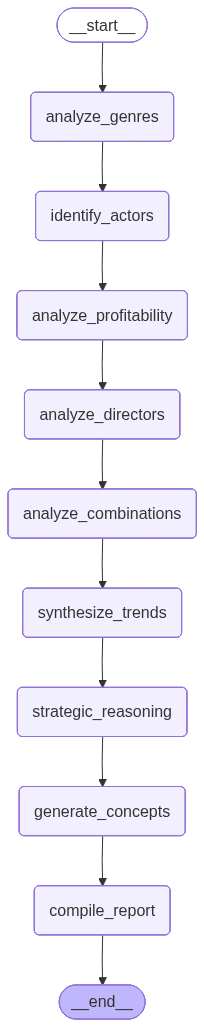

In [7]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(app.get_graph().draw_mermaid_png()))

In [8]:
initial_state = {
    "analysis_focus": "comprehensive"
}

result = app.invoke(initial_state)

In [9]:
print(result['final_report'])

# Movie Production Recommendations

## Concept Slate

### 1. Echoes of the Front

**War + Documentary**

*An immersive cinematic documentary that stitches archival footage, 16mm reenactment, and present-day testimony into a living memory of one forgotten frontline — guided by a single, quietly unnerving narrator.*

["We meet our principal guide — an offbeat, intimate narrator whose voice threads the film — as the movie opens on grainy archival frames and slow, Ron Fricke-style tracking shots over abandoned trenches and ruined towns. The world is set: a mid-20th-century conflict zone reconstructed through found footage, recovered letters, and tactile reenactments shot on 16mm; the film deliberately blurs line between recall and myth. We also meet three veterans (on-camera interviews), a young archivist obsessed with a single unit's fate, and communities still living in the war’s shadow.", 'The inciting incident is the discovery of a hidden field journal that contradicts the official his